# Machine Learning Project

## Imports

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint
import pathlib
import PIL
import os
import time
import datetime

import matplotlib.pyplot as plt
import matplotlib
#set fonts to display labels correctly
matplotlib.rcParams.update(
    {
        'text.usetex': False,
        'font.family': 'MS Gothic'
    }
)


## Check GPUs

In [2]:
print("GPUs Available: ", tf.test.gpu_device_name())

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

tf.keras.mixed_precision.set_global_policy("mixed_float16")

GPUs Available:  /device:GPU:0
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 2070 SUPER, compute capability 7.5


## Load Data

Data stored as 201 images per character, each character's images are grouped in folders labelled with the character.

610236


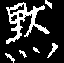

In [3]:

data_dir = pathlib.Path('Data/characters')

image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

shutup = list(data_dir.glob('黙/*'))
PIL.Image.open(str(shutup[0]))


## Creating the data pipeline

first parameters for loading

In [4]:
batch_size = 4096
img_height = 63
img_width = 64

Split the data into 80% testing and 20% training

In [5]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode='grayscale',
  shuffle=True)


val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode='grayscale',
  shuffle=True)


class_names = train_ds.class_names
#print(class_names)


Found 610236 files belonging to 3036 classes.
Using 488189 files for training.
Found 610236 files belonging to 3036 classes.
Using 122047 files for validation.


Print out some of the images to test everything is working

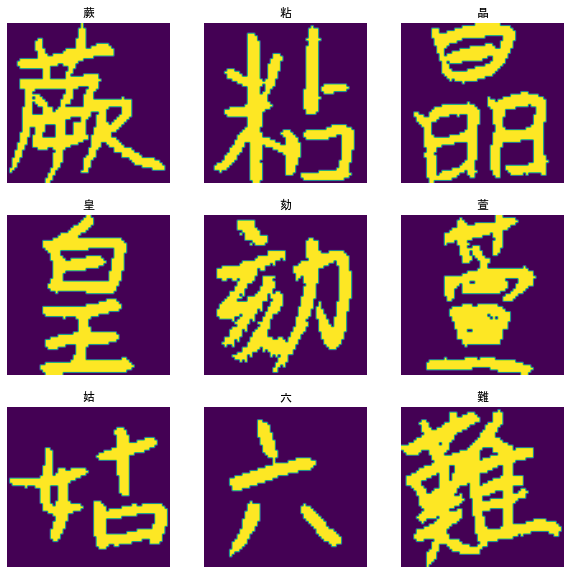

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")


# Train the model

## Configure dataset
todo remove .cache()

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

def configure_for_performance(ds):
  #ds = ds.cache()
  #ds = ds.shuffle(buffer_size=batch_size)
  #ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)


## Set up model

structure from Charlie Tsai. (2016). Recognizing Handwritten Japanese Characters Using Deep Convolutional Neural Networks. 1–7.

In [8]:
from models import *

model = get_M7_1(len(class_names))


model.summary()

Model: "M7_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2D_1_1_input (Conv2D)    (None, 61, 62, 32)        320       
_________________________________________________________________
maxpool_1 (MaxPooling2D)     (None, 30, 31, 32)        0         
_________________________________________________________________
conv2D_2_1 (Conv2D)          (None, 28, 29, 128)       36992     
_________________________________________________________________
maxpool_2 (MaxPooling2D)     (None, 14, 14, 128)       0         
_________________________________________________________________
conv2D_3_1 (Conv2D)          (None, 12, 12, 512)       590336    
_________________________________________________________________
conv2D_3_2 (Conv2D)          (None, 10, 10, 512)       2359808   
_________________________________________________________________
maxpool_3 (MaxPooling2D)     (None, 5, 5, 512)         0      

In [9]:
model_dir = './models/'

filepath = os.path.join(model_dir, "tf", "checkpoints", "weights-improvement-{epoch:02d}-{val_accuracy:.2f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

log_dir = os.path.join(model_dir, "tf", "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

callbacks_list = [checkpoint, tensorboard_callback]

In [10]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001,
                                beta_1=0.9,
                                beta_2=0.999,
                                epsilon=1e-08,)


model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(
    x=train_ds,
    epochs=150,
    initial_epoch=0,
    validation_data=val_ds,
    callbacks=callbacks_list,
    workers=1)

Epoch 1/150
  1/120 [..............................] - ETA: 3:57:48 - loss: 8.0184 - accuracy: 2.4414e-04

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted:  OOM when allocating tensor with shape[4096,12,12,512] and type half on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/M7_1/conv2D_3_2/Conv2D/Conv2DBackpropInput (defined at <ipython-input-10-2992de8492d8>:11) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[cond/then/_0/cond/GreaterEqual/_28]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted:  OOM when allocating tensor with shape[4096,12,12,512] and type half on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node gradient_tape/M7_1/conv2D_3_2/Conv2D/Conv2DBackpropInput (defined at <ipython-input-10-2992de8492d8>:11) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_1732]

Function call stack:
train_function -> train_function


In [ ]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1.0])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test,  y_test, verbose=2)

print(test_acc)